# Artificial Neural Networks and Deep Learning

---

## Homework 2: Semantic Segmentation
This notebook contains one possible structure for the second homework of the AN2DL course. The goal is to perform semantic segmentation on a specific set of images, collected from Mars surface.

## TODO:
* Il test set non presenta particolari augmentations, le immagini sembrano le stesse del train set
* La classe di Background (label = 0) non è inclusa nella valutazione del MeanIoU e pertanto è da escludersi.

* Da questo video (https://www.youtube.com/watch?v=azM57JuQpQI&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE) si nota che viene anche usato un layer di dropout con rate piccolo (0.1) durante la convoluzione: può aiutare?

## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import keras_cv as kcv
from sklearn.model_selection import train_test_split

seed = 42
# np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [2]:
## ⏳ Load the Data

In [3]:
# Load the entire dataset

data = np.load("/kaggle/input/mars-for-students/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## 👀 Inspect the dataset
Dataset inspection is meant to find possible outliers in the images, detect duplicates and, more in general, to do everything connected to data cleaning and pre-processing.

[1213  177 1251  517 1464 2334   70 2461  441  591]


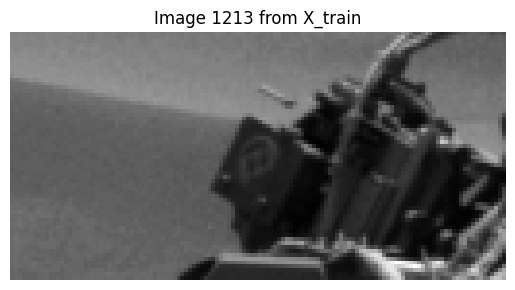

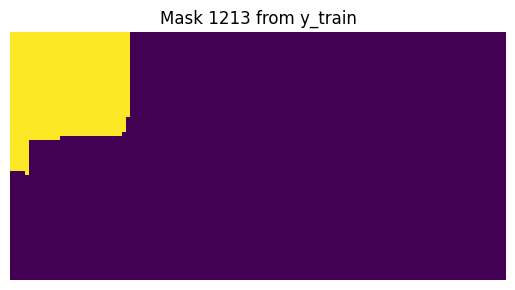

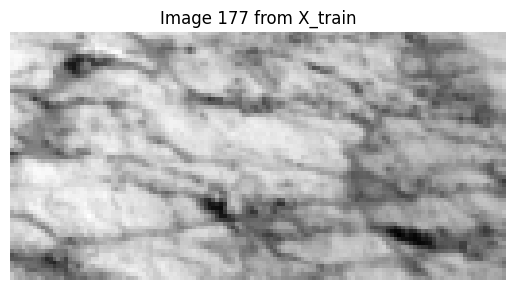

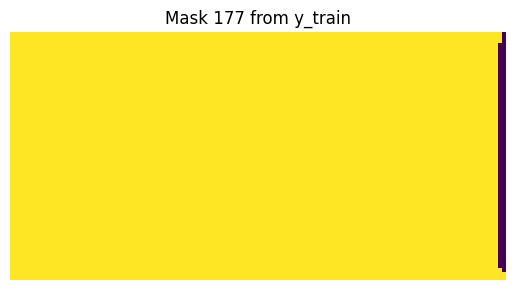

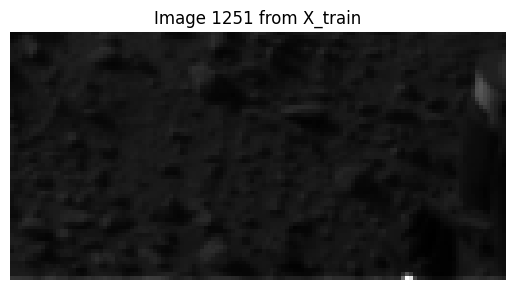

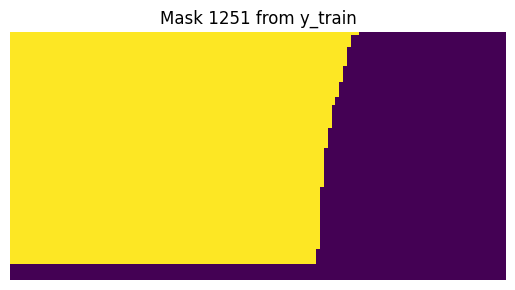

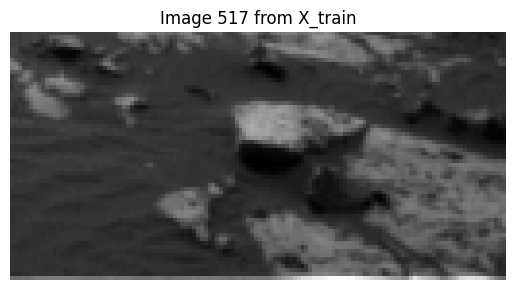

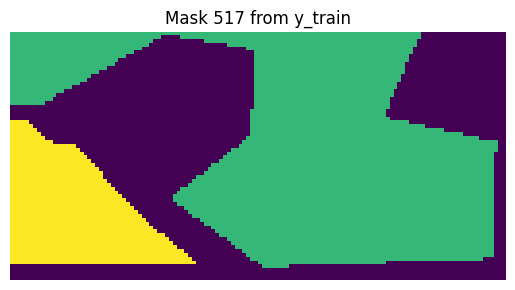

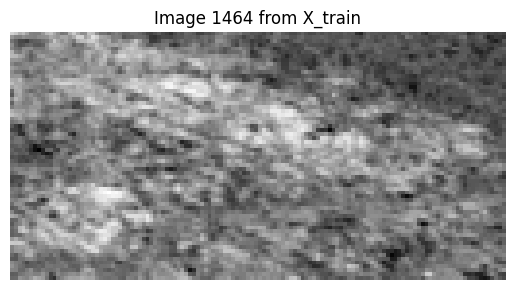

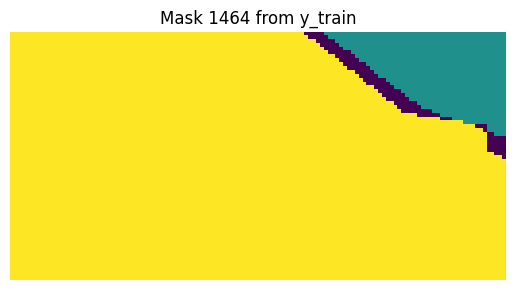

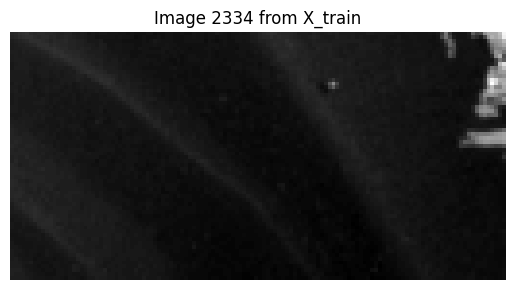

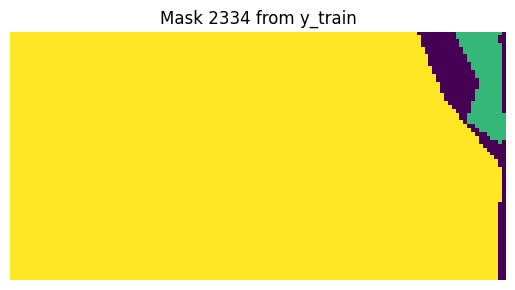

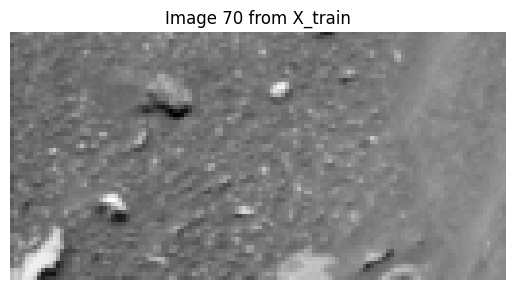

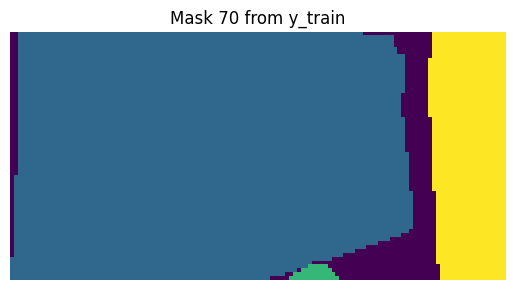

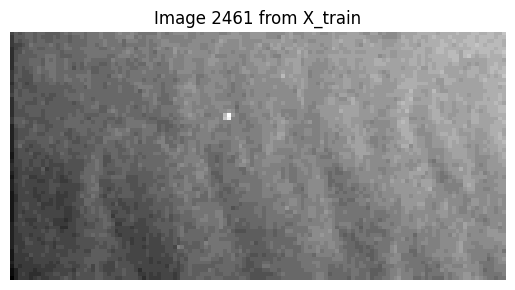

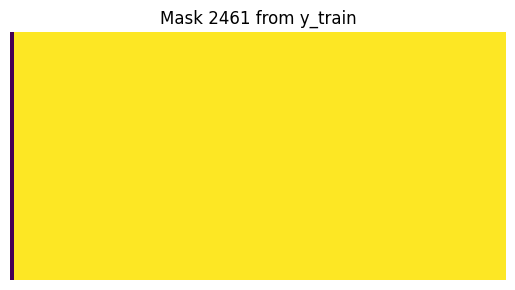

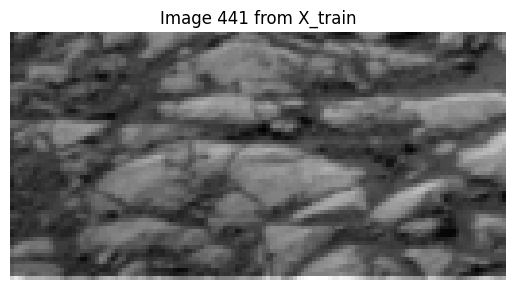

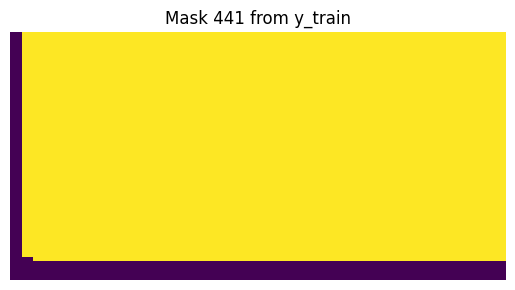

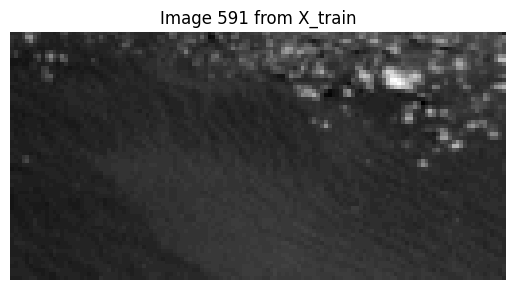

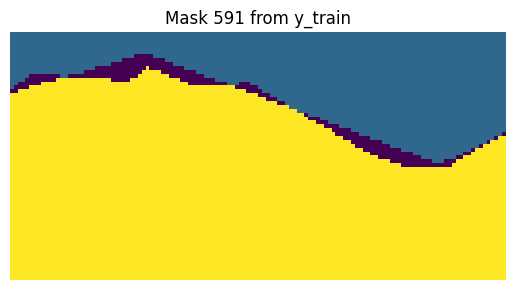

In [4]:
# Create a random index to display every time a different set of images
X_train_size = X_train.shape[0]
random_indices = np.random.randint(0, X_train_size, size = 10)
print(random_indices)

# Plot the image
for index in random_indices:
    plt.imshow(X_train[index], cmap='gray')
    plt.title(f"Image {index} from X_train")
    plt.axis('off')
    plt.show()
    
    plt.imshow(y_train[index])
    plt.title(f"Mask {index} from y_train")
    plt.axis('off')
    plt.show()

### 🧹 Remove the Outliers
Analysing the *X_train* and *y_train* sets, it is possible to notice some outliers. For example, there are some pictures (e.g. the one with index 62) contains the picture of an alien. 

By understanding both the pictures and the masks, the masks seems to be the same even if the alien picture is flipped. So we can scan all the masks that are the same of picture 62 and then remove them from the dataset.

In [5]:
# This function establish if image1 and image2 are the same images, pixel-wise.
def are_same_mask (image1, image2):
    if image1.shape != image2.shape:
        print("[ERROR] The images are not the same size.")
        return False
    return np.array_equal(image1, image2)

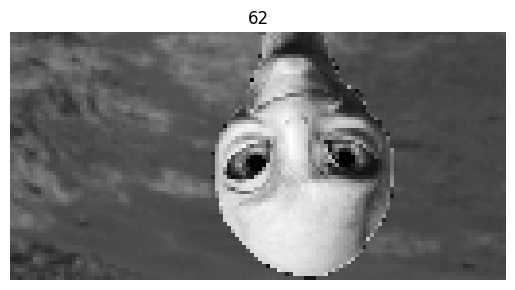

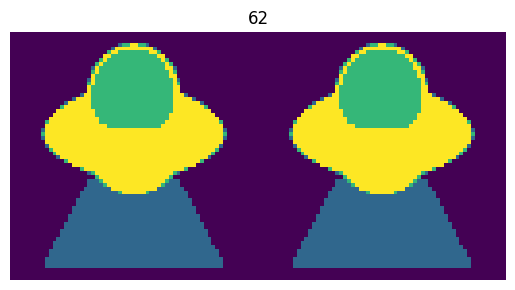

In [6]:
# Show the first picture of an alien
first_alien_index = 62
alien_indices = []
alien_indices.append(first_alien_index)

plt.imshow(X_train[first_alien_index], cmap='gray')
plt.title(first_alien_index)
plt.axis('off')
plt.show()

plt.imshow(y_train[first_alien_index])
plt.title(first_alien_index)
plt.axis('off')
plt.show()

In [7]:
# Detect all the images with the same masks as of the first alien
for i in range(X_train_size):
    if i != first_alien_index and are_same_mask(y_train[first_alien_index], y_train[i]):
        alien_indices.append(i)

print(f"{len(alien_indices)} images have the same mask of the first alien picture:")
print(alien_indices)

110 images have the same mask of the first alien picture:
[62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]


In [8]:
# Delete from X_train and y_train all the images with index in alien_indices
X_train = np.delete(X_train, alien_indices, axis=0)
y_train = np.delete(y_train, alien_indices, axis=0)

print("Shape of X_train without aliens: ", X_train.shape)
print("Shape of y_train without aliens: ", y_train.shape)

Shape of X_train without aliens:  (2505, 64, 128)
Shape of y_train without aliens:  (2505, 64, 128)


## 🪓 Split into training and validation set
The training set provided via the arrays *X_train* and *y_train* should be splitted into a new effective training set and a validation set.

In [9]:
# Split into training and validation set with a 80/20 ratio.
X_train, X_val, y_train, y_val = train_test_split (
    X_train, y_train, test_size = 0.2, random_state = seed
)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (2004, 64, 128)
y_train shape:  (2004, 64, 128)
X_val shape:  (501, 64, 128)
y_val shape:  (501, 64, 128)


## ☀️ Augmenting the training set
In this section we perform some static augmentations to the training set.

In [10]:
import numpy as np
import random

def apply_random_crop_to_new_image(image, ground_truth, min_crop_size=(16, 32), max_crop_size=(64, 128)):
    # Ottieni le dimensioni dell'immagine originale
    h, w = image.shape
    
    # Genera dimensioni casuali per la porzione da copiare
    crop_h = random.randint(min_crop_size[0], max_crop_size[0])
    crop_w = random.randint(min_crop_size[1], max_crop_size[1])
    
    # Assicurati che la porzione scelta possa stare dentro l'immagine
    if crop_h > h or crop_w > w:
        raise ValueError("La porzione da copiare è più grande dell'immagine")

    # Scegli una posizione casuale per la porzione da copiare nell'immagine
    top = random.randint(0, h - crop_h)
    left = random.randint(0, w - crop_w)
    
    # Crea le nuove immagini vuote
    new_image = np.zeros((h, w), dtype=np.uint8)  # Immagine vuota
    new_ground_truth = np.zeros((h, w), dtype=np.uint8)  # Ground truth vuoto
    
    # Copia la porzione di immagine e ground truth nella posizione scelta
    new_image[top:top+crop_h, left:left+crop_w] = image[top:top+crop_h, left:left+crop_w]
    new_ground_truth[top:top+crop_h, left:left+crop_w] = ground_truth[top:top+crop_h, left:left+crop_w]
    
    return new_image, new_ground_truth

def create_new_datasets(images, ground_truths):
    new_images = []
    new_ground_truths = []
    
    # Itera su ogni immagine e ground truth
    for i in range(images.shape[0]):
        image = images[i]
        ground_truth = ground_truths[i]
        
        new_image, new_ground_truth = apply_random_crop_to_new_image(image, ground_truth)
        
        new_images.append(new_image)
        new_ground_truths.append(new_ground_truth)
    
    # Converti le liste in array NumPy
    new_images = np.array(new_images)
    new_rn_ground_truths = np.array(new_ground_truths)
    
    return new_images, new_ground_truths

# Esempio di utilizzo:
# Supponiamo che `images` e `ground_truths` siano i tuoi dataset (entrambi con shape (2500, 64, 128))
# images = np.random.randint(0, 256, size=(2500, 64, 128), dtype=np.uint8)
# ground_truths = np.random.randint(0, 6, size=(2500, 64, 128), dtype=np.uint8)

# Nuovi dataset con porzioni random
X_train_crop, y_train_crop = create_new_datasets(X_train, y_train)

# new_images e new_ground_truths conterranno i nuovi dataset creati


In [11]:
# Define a custom function for random horizontal/vertical flip
def random_flip (train_img, train_mask, threshold=0.5):
    for i in range(train_img.shape[0]):
        h_or_v = 0 if np.random.uniform(0, 1) < threshold else 1
        train_img[i] = cv2.flip(train_img[i], h_or_v)
        train_mask[i] = cv2.flip(train_mask[i], h_or_v)
    return train_img, train_mask

In [12]:
X_train_len = int(X_train.shape[0] * 1)

# Perform random horizontal/vertical flip on a copy of the first half of the dataset
X_train_flip = np.array(X_train[:X_train_len], copy = True)
y_train_flip = np.array(y_train[:X_train_len], copy = True)
X_train_copy, y_train_copy = random_flip(X_train_flip, y_train_flip)

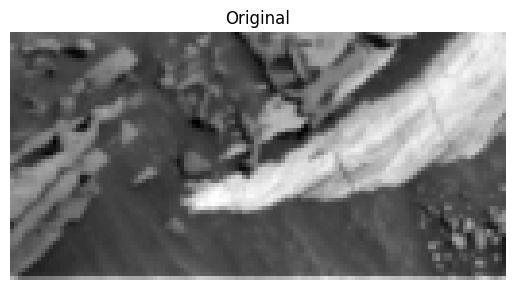

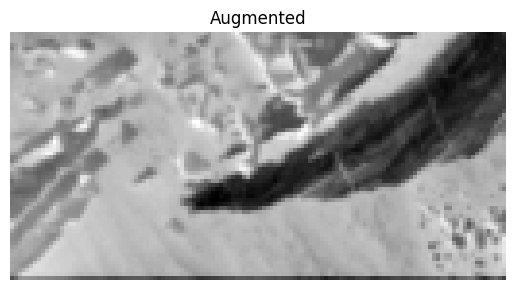

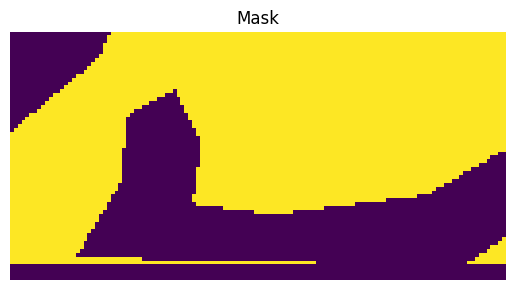

In [13]:
# Apply Solarization to a portion of the dataset
X_train_solar = np.array(X_train[:X_train_len], copy = True)
y_train_solar = np.array(y_train[:X_train_len], copy = True)

solarization = kcv.layers.Solarization(value_range=(0, 255))
X_train_solar = solarization(X_train_solar)

# Plot an example
# Display one random image and the corresponding mask containing an alien
rand_i = np.random.randint(0, X_train_solar.shape[0])

plt.imshow(X_train[rand_i], cmap='gray')
plt.title("Original")
plt.axis('off')
plt.show()

plt.imshow(X_train_solar[rand_i], cmap='gray')
plt.title("Augmented")
plt.axis('off')
plt.show()

plt.imshow(y_train_solar[rand_i])
plt.title("Mask")
plt.axis('off')
plt.show()

In [14]:
# Concatenate the obtained results
X_train = np.concatenate([X_train, X_train_flip], axis=0)
y_train = np.concatenate([y_train, y_train_flip], axis=0)

# Concatenate the obtained results
X_train = np.concatenate([X_train, X_train_solar], axis=0)
y_train = np.concatenate([y_train, y_train_solar], axis=0)

# Concatenate the obtained results
X_train = np.concatenate([X_train, X_train_crop], axis=0)
y_train = np.concatenate([y_train, y_train_crop], axis=0)

In [15]:
# Apply RandomContrast to the entire dataset
# rand_contrast = tfkl.RandomContrast(factor=0.3, seed=seed)
# X_train = rand_contrast(X_train)

In [16]:
# Apply RandomBrightness to the entire dataset
# rand_bn = tfkl.RandomBrightness(factor=0.2, value_range=(0, 255), seed=seed)
# X_train = rand_bn(X_train)

In [17]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# Retrieve the shape of the input
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


## 🛠️ Models and Experiments
A first experiment of the model is done by building from scratch the U-Net architecture.

In [18]:
# Define network hyperparameters
batch_size = 128
learning_rate = 1e-3
epochs = 200

print("Batch size: ", batch_size)
print("Initial learning rate: ", learning_rate)
print("Epochs: ", epochs)

Batch size:  128
Initial learning rate:  0.001
Epochs:  200


In [19]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=3, name='',num=0):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
        if(i+1 == stack -1):
            x = tfkl.Dropout(0.1*num)(x)

    # Return the transformed tensor
    return x

In [20]:
def get_unet_model(input_shape=(64, 128, 3), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 64, name='down_block1_',num=0)
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 128, name='down_block2_',num=0)
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 256, name='down_block3_',num=1)
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 512, name='down_block4_',num=2)
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 1024, name='bottleneck',num=5)
    
    # Upsampling path
    
    #u4 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    u4 = tfkl.UpSampling2D()(bottleneck)
    u4 = tfkl.Concatenate()([u4, down_block_4])
    u4 = unet_block(u4, 512, name='up_block4_',num=2)
    #u3 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    u3 = tfkl.UpSampling2D()(u4)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block(u3, 256, name='up_block3_',num=1)
    
    #u2 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(u3)
    u2 = tfkl.UpSampling2D()(u3)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 128, name='up_block2_',num=0)

    #u1 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u2)
    u1 = tfkl.UpSampling2D()(u2)
    u1 = tfkl.Concatenate()([u1, down_block_1])
    u1 = unet_block(u1, 64, name='up_block1_',num=0)

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [21]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [22]:
# Define custom Mean Intersection Over Union metric
# By default, no classes are excluded.
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_io_u", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [23]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tfk.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [24]:
# Generalized Dice Loss
def generalized_dice_loss(y_true, y_pred):
    # Ensure predictions are normalized
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)
    
    # Compute per-class weights
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(0, 1, 2))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(0, 1, 2))
    weights = 1 / (tf.reduce_sum(y_true, axis=(0, 1, 2)) ** 2 + 1e-6)
    
    # Generalized Dice Score
    dice_score = tf.reduce_sum(weights * numerator) / tf.reduce_sum(weights * denominator)
    
    # Loss is 1 - Dice Score
    return 1 - dice_score
    
def combined_loss(y_true, y_pred, num_classes=5, alpha=0.5, beta=0.5, gamma=0):
    # Convert y_true to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    
    # Exclude the background class (label 0)
    y_true_one_hot = y_true_one_hot[..., 1:]  # Ignore background in ground truth
    y_pred = y_pred[..., 1:]  # Ignore background in predictions

    # Ensure predictions are normalized
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)

    # 1. Generalized Dice Loss
    gen_dice_loss = generalized_dice_loss(y_true_one_hot, y_pred)
    
    # 2. Focal Loss
    gamma_focal = 2.0
    focal_loss = -tf.reduce_mean(
        tf.reduce_sum(
            y_true_one_hot * ((1 - y_pred) ** gamma_focal) * tf.math.log(y_pred), axis=-1
        )
    )
    
    #4. Boundary loss
    def erosion2d_custom(tensor, d=1):
            kernel = tf.ones((d, d, tensor.shape[-1]), dtype=tf.float32)  # Create kernel
            kernel = tf.expand_dims(kernel, axis=-1)  # [d, d, channels, 1]
            eroded = tf.nn.depthwise_conv2d(
                input=tensor,
                filter=kernel,
                strides=[1, 1, 1, 1],
                padding="SAME"
            )
            return tf.cast(eroded == tf.reduce_sum(kernel), dtype=tf.float32)
    
    def boundary_dou_loss(y_true, y_pred, d=1):
        
        # Ensure predictions are between 0 and 1
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        
        # Create the boundary mask
        kernel = tf.ones((d, d, 4), dtype=tf.float32)
        y_true_eroded = erosion2d_custom(y_true)
        y_pred_eroded= erosion2d_custom(y_pred)
    
        # Boundary regions are the difference between original and eroded masks
        y_true_boundary = y_true - y_true_eroded
        y_pred_boundary = y_pred - y_pred_eroded
    
        # Calculate Intersection and Union on the boundary
        intersection = tf.reduce_sum(y_true_boundary * y_pred_boundary, axis=[1, 2])
        union = tf.reduce_sum(y_true_boundary + y_pred_boundary, axis=[1, 2]) - intersection
    
        # Calculate area and circumference for weighting term
        area = tf.reduce_sum(y_true, axis=[1, 2])
        circumference = tf.reduce_sum(y_true_boundary, axis=[1, 2])
    
        # Compute alpha
        alpha = 1 - 2 * (circumference / (area + 1e-6))
        alpha = tf.clip_by_value(alpha, 0, 1)
    
        # Compute Boundary DoU loss
        loss = (union - intersection) / (union - alpha * intersection + 1e-6)
    
        # Reduce mean over the batch
        return tf.reduce_mean(loss)

    boundary_loss = boundary_dou_loss(y_true_one_hot, y_pred)
    
    # Combine the losses with weights
    total_loss = alpha * gen_dice_loss + beta * focal_loss + gamma * boundary_loss
    
    return total_loss

In [25]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, original_image, original_mask, num_classes, frequency=5):
        super().__init__()
        self.original_image = original_image   # Define the original image
        self.original_mask = original_mask     # Define the original mask
        self.num_classes = num_classes         # Define the number of classes
        self.frequency = frequency             # Define the visualization frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image = np.expand_dims(self.original_image, axis=0)  # Add batch dimension
            pred = self.model.predict(image, verbose=0)            
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.original_image, cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(apply_colormap(self.original_mask, colormap))
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred, colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()            

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,928 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 64, 128, │         0 │ down_block1_a… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv3 │ (None, 64, 128, │    36,928 │ dropout[0][0]  │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn3   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,584 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y 

 Total params: 47,120,389 (179.75 MB)

 Trainable params: 47,102,725 (179.68 MB)

 Non-trainable params: 17,664 (69.00 KB)

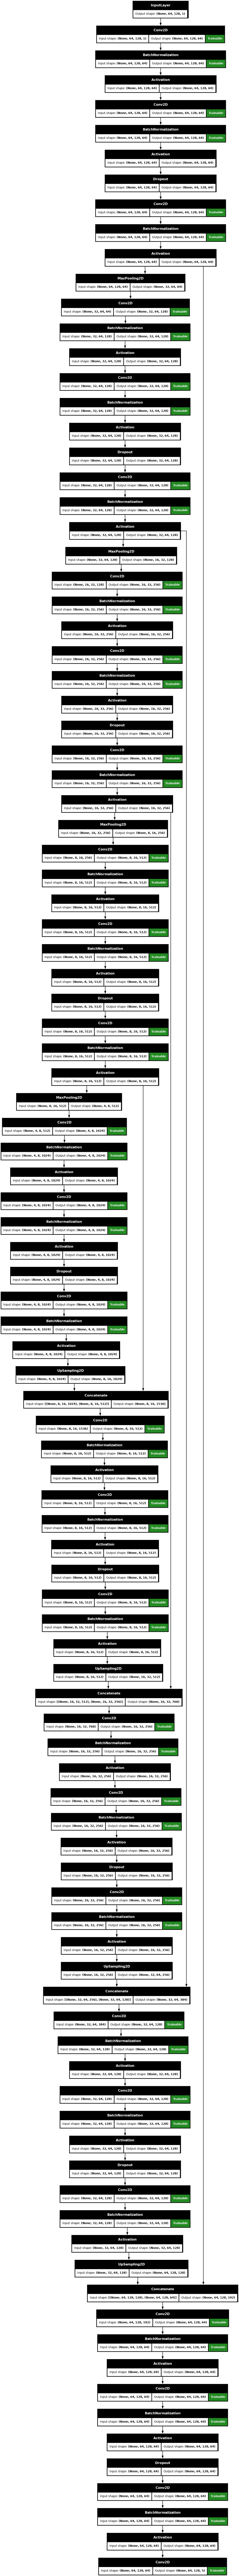

In [26]:
# Define the model
model = get_unet_model(input_shape=input_shape, num_classes=num_classes)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=False, show_shapes=True, dpi=70)

In [27]:
# Define the MeanIoU ignoring the background class
mean_iou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])
optimizer = tfk.optimizers.AdamW()

model.compile(
    loss=[combined_loss],
    optimizer=optimizer,
    metrics=["accuracy", mean_iou]
)

model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,928 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 64, 128, │         0 │ down_block1_a… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv3 │ (None, 64, 128, │    36,928 │ dropout[0][0]  │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn3   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,584 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y 

 Total params: 47,120,389 (179.75 MB)

 Trainable params: 47,102,725 (179.68 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [28]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping (
    monitor='val_mean_iou',
    mode='max',
    patience=40,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau (
    monitor='val_loss',
    mode='min',
    patience=30,
    factor=0.1,
    min_lr=1e-6
) 

random_viz = np.random.randint(0, X_val.shape[0])
print("Showing evolution on image", random_viz)
viz_callback = VizCallback(X_val[random_viz], y_val[random_viz], num_classes)

callbacks = [early_stopping, reduce_lr, viz_callback]

Showing evolution on image 482


Epoch 1/200


I0000 00:00:1733268218.850562      94 service.cc:145] XLA service 0x7ac0d4008220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733268218.850613      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/251 ━━━━━━━━━━━━━━━━━━━━ 3:15:53 47s/step - accuracy: 0.1609 - loss: 0.8764 - mean_iou: 0.0958

I0000 00:00:1733268249.645632      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.3427 - loss: 0.6762 - mean_iou: 0.1660

I0000 00:00:1733268313.462261      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_22', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_25', 16 bytes spill stores, 16 bytes spill loads



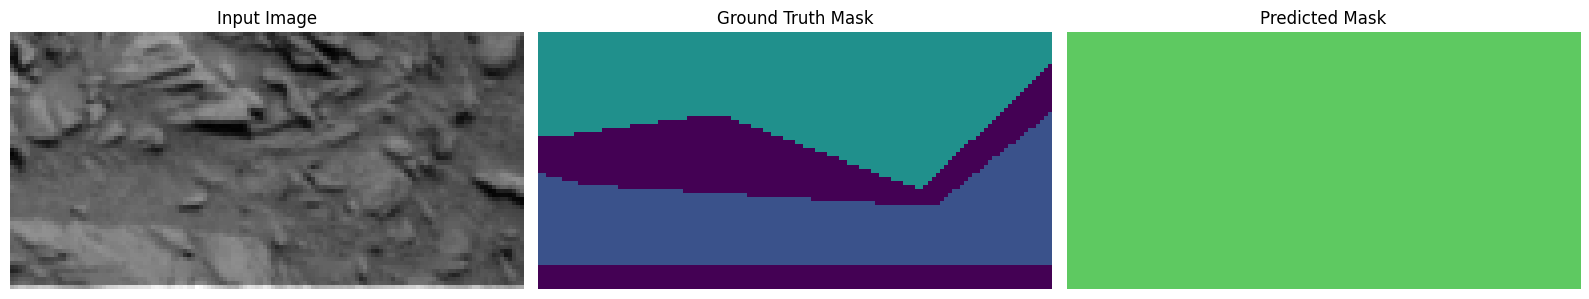

251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 319ms/step - accuracy: 0.3428 - loss: 0.6761 - mean_iou: 0.1661 - val_accuracy: 0.1979 - val_loss: 1.4691 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 2/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.3365 - loss: 0.6141 - mean_iou: 0.2037 - val_accuracy: 0.3715 - val_loss: 0.6740 - val_mean_iou: 0.2155 - learning_rate: 0.0010
Epoch 3/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.3662 - loss: 0.5950 - mean_iou: 0.3025 - val_accuracy: 0.4177 - val_loss: 0.6541 - val_mean_iou: 0.2922 - learning_rate: 0.0010
Epoch 4/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.3869 - loss: 0.5920 - mean_iou: 0.3288 - val_accuracy: 0.4602 - val_loss: 0.6464 - val_mean_iou: 0.2967 - learning_rate: 0.0010
Epoch 5/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.4429 - loss: 0.5786 - mean_iou: 0.3993 - val_accuracy: 0.4439 - val_loss: 0.6212 - val_mean_iou: 0.3222 - learning_rate: 0.0010
Epoch 6/200
251/251 ━

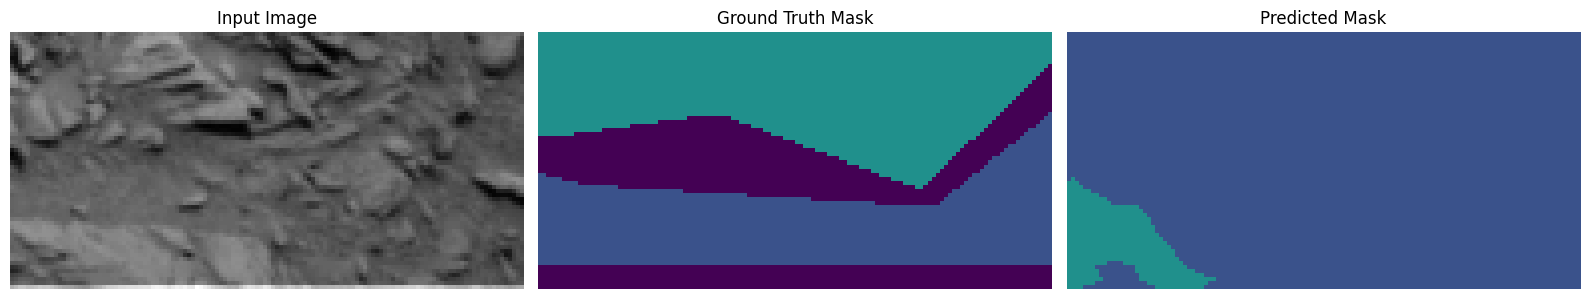

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.4696 - loss: 0.5731 - mean_iou: 0.4336 - val_accuracy: 0.4881 - val_loss: 0.6250 - val_mean_iou: 0.3427 - learning_rate: 0.0010
Epoch 7/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.4837 - loss: 0.5675 - mean_iou: 0.4565 - val_accuracy: 0.5006 - val_loss: 0.6052 - val_mean_iou: 0.4013 - learning_rate: 0.0010
Epoch 8/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.4962 - loss: 0.5634 - mean_iou: 0.4746 - val_accuracy: 0.5132 - val_loss: 0.6940 - val_mean_iou: 0.3810 - learning_rate: 0.0010
Epoch 9/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5084 - loss: 0.5594 - mean_iou: 0.4947 - val_accuracy: 0.5715 - val_loss: 0.5683 - val_mean_iou: 0.4671 - learning_rate: 0.0010
Epoch 10/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5058 - loss: 0.5584 - mean_iou: 0.4936 - val_accuracy: 0.5338 - val_loss: 0.6091 - val_mean_iou: 0.4509 - learning_rate: 0.0010
Epoch 11/200
251/251 

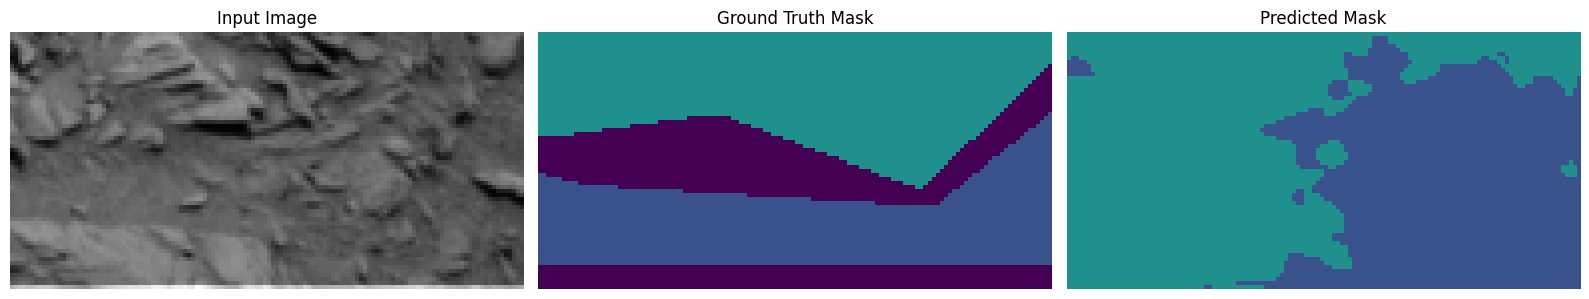

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5056 - loss: 0.5569 - mean_iou: 0.4922 - val_accuracy: 0.6196 - val_loss: 0.5554 - val_mean_iou: 0.5254 - learning_rate: 0.0010
Epoch 12/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5197 - loss: 0.5494 - mean_iou: 0.5179 - val_accuracy: 0.5108 - val_loss: 0.7141 - val_mean_iou: 0.3735 - learning_rate: 0.0010
Epoch 13/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.4991 - loss: 0.5556 - mean_iou: 0.4874 - val_accuracy: 0.5535 - val_loss: 0.6144 - val_mean_iou: 0.4265 - learning_rate: 0.0010
Epoch 14/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5075 - loss: 0.5538 - mean_iou: 0.4992 - val_accuracy: 0.5746 - val_loss: 0.5683 - val_mean_iou: 0.4785 - learning_rate: 0.0010
Epoch 15/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5006 - loss: 0.5523 - mean_iou: 0.4923 - val_accuracy: 0.6178 - val_loss: 0.5585 - val_mean_iou: 0.5239 - learning_rate: 0.0010
Epoch 16/200
251/2

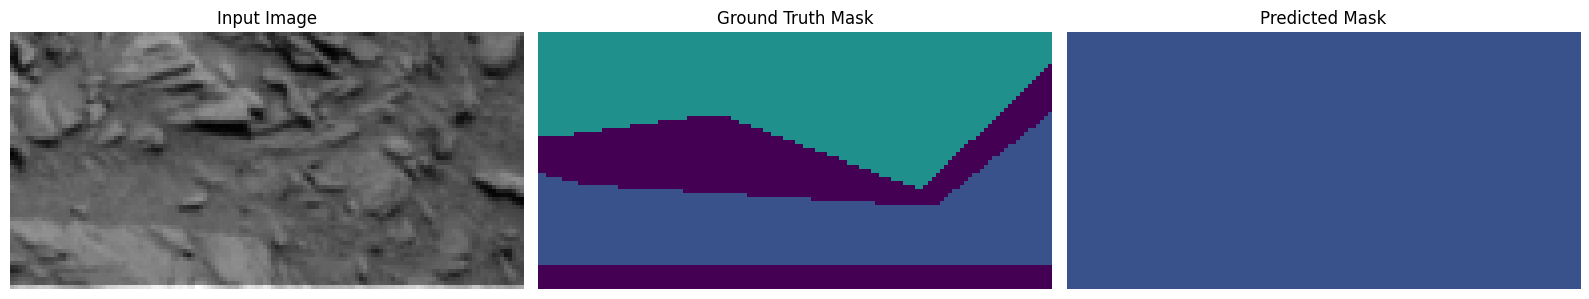

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5235 - loss: 0.5464 - mean_iou: 0.5262 - val_accuracy: 0.5530 - val_loss: 0.6399 - val_mean_iou: 0.4371 - learning_rate: 0.0010
Epoch 17/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5102 - loss: 0.5490 - mean_iou: 0.5073 - val_accuracy: 0.6039 - val_loss: 0.5470 - val_mean_iou: 0.5248 - learning_rate: 0.0010
Epoch 18/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5216 - loss: 0.5451 - mean_iou: 0.5247 - val_accuracy: 0.5108 - val_loss: 0.5949 - val_mean_iou: 0.3660 - learning_rate: 0.0010
Epoch 19/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5244 - loss: 0.5436 - mean_iou: 0.5259 - val_accuracy: 0.6230 - val_loss: 0.5586 - val_mean_iou: 0.5204 - learning_rate: 0.0010
Epoch 20/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5240 - loss: 0.5427 - mean_iou: 0.5250 - val_accuracy: 0.6044 - val_loss: 0.5413 - val_mean_iou: 0.5489 - learning_rate: 0.0010
Epoch 21/200
251/2

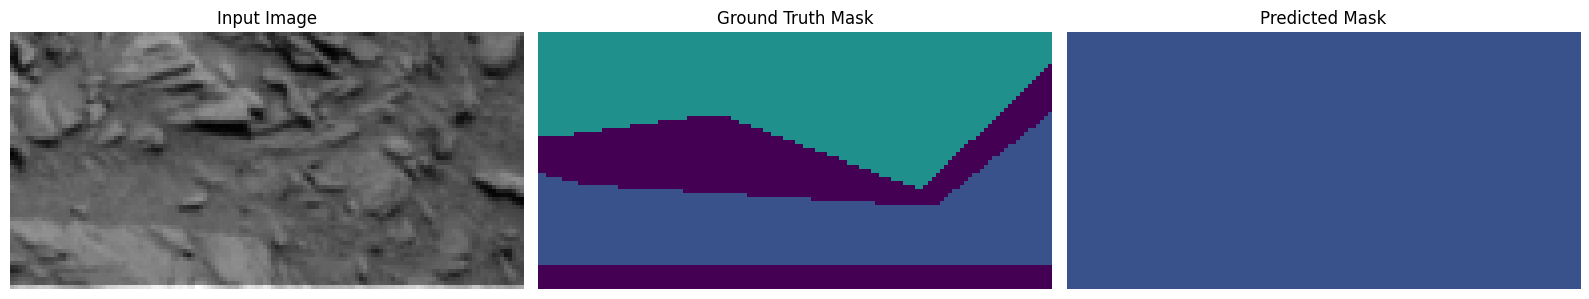

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.5270 - loss: 0.5409 - mean_iou: 0.5301 - val_accuracy: 0.5605 - val_loss: 0.5958 - val_mean_iou: 0.4501 - learning_rate: 0.0010
Epoch 22/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5276 - loss: 0.5393 - mean_iou: 0.5328 - val_accuracy: 0.5854 - val_loss: 0.5527 - val_mean_iou: 0.4951 - learning_rate: 0.0010
Epoch 23/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5323 - loss: 0.5370 - mean_iou: 0.5434 - val_accuracy: 0.5344 - val_loss: 0.9305 - val_mean_iou: 0.4098 - learning_rate: 0.0010
Epoch 24/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5327 - loss: 0.5371 - mean_iou: 0.5474 - val_accuracy: 0.6426 - val_loss: 0.5235 - val_mean_iou: 0.6296 - learning_rate: 0.0010
Epoch 25/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5320 - loss: 0.5338 - mean_iou: 0.5477 - val_accuracy: 0.5784 - val_loss: 0.5825 - val_mean_iou: 0.4488 - learning_rate: 0.0010
Epoch 26/200
251/2

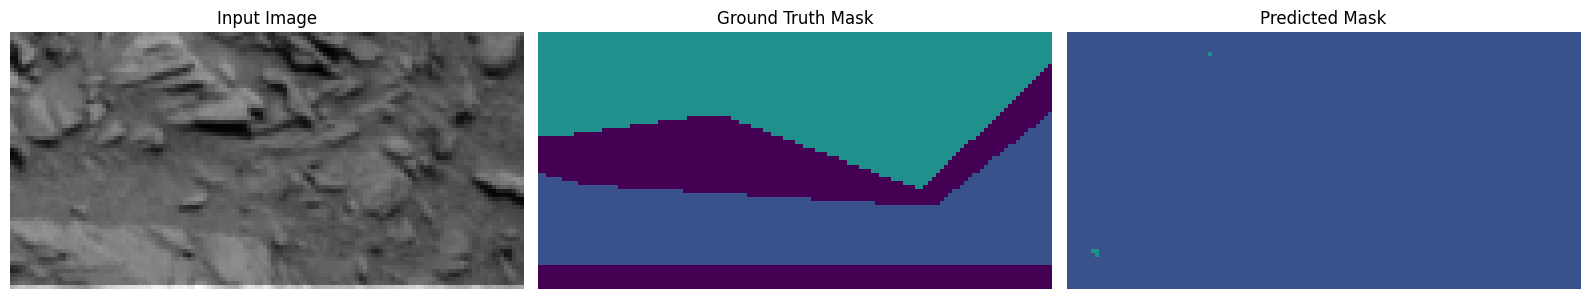

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5327 - loss: 0.5299 - mean_iou: 0.5515 - val_accuracy: 0.6166 - val_loss: 0.5666 - val_mean_iou: 0.5069 - learning_rate: 0.0010
Epoch 27/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5398 - loss: 0.5309 - mean_iou: 0.5575 - val_accuracy: 0.6023 - val_loss: 0.5692 - val_mean_iou: 0.5076 - learning_rate: 0.0010
Epoch 28/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5421 - loss: 0.5296 - mean_iou: 0.5642 - val_accuracy: 0.6347 - val_loss: 0.5492 - val_mean_iou: 0.5435 - learning_rate: 0.0010
Epoch 29/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5363 - loss: 0.5253 - mean_iou: 0.5581 - val_accuracy: 0.5930 - val_loss: 0.5665 - val_mean_iou: 0.4857 - learning_rate: 0.0010
Epoch 30/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.5278 - loss: 0.5264 - mean_iou: 0.5430 - val_accuracy: 0.4340 - val_loss: 0.5971 - val_mean_iou: 0.3347 - learning_rate: 0.0010
Epoch 31/200
251/2

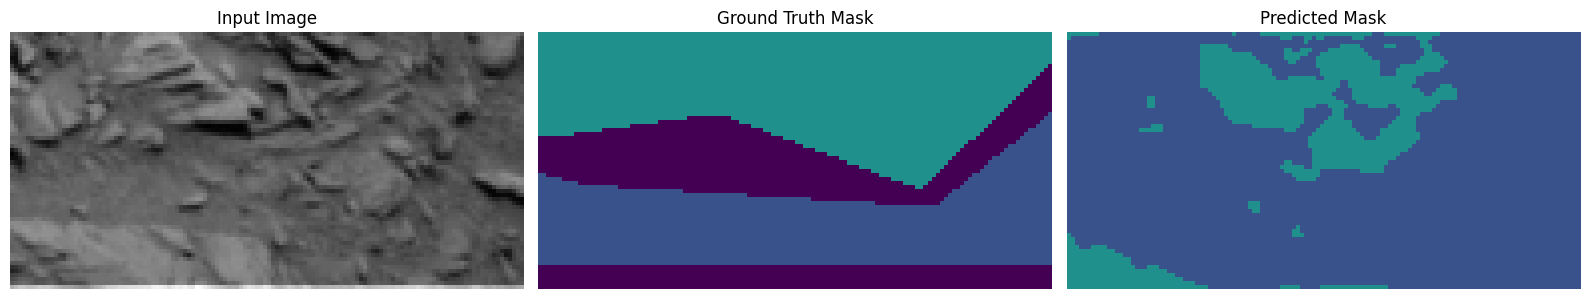

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.4983 - loss: 0.5537 - mean_iou: 0.4896 - val_accuracy: 0.6449 - val_loss: 0.5308 - val_mean_iou: 0.5970 - learning_rate: 0.0010
Epoch 32/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.4905 - loss: 0.5512 - mean_iou: 0.4776 - val_accuracy: 0.6451 - val_loss: 0.5449 - val_mean_iou: 0.5626 - learning_rate: 0.0010
Epoch 33/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5270 - loss: 0.5321 - mean_iou: 0.5348 - val_accuracy: 0.6458 - val_loss: 0.5319 - val_mean_iou: 0.5975 - learning_rate: 0.0010
Epoch 34/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5406 - loss: 0.5213 - mean_iou: 0.5649 - val_accuracy: 0.6518 - val_loss: 0.5411 - val_mean_iou: 0.5701 - learning_rate: 0.0010
Epoch 35/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5343 - loss: 0.5231 - mean_iou: 0.5543 - val_accuracy: 0.6009 - val_loss: 0.5421 - val_mean_iou: 0.5340 - learning_rate: 0.0010
Epoch 36/200
251/2

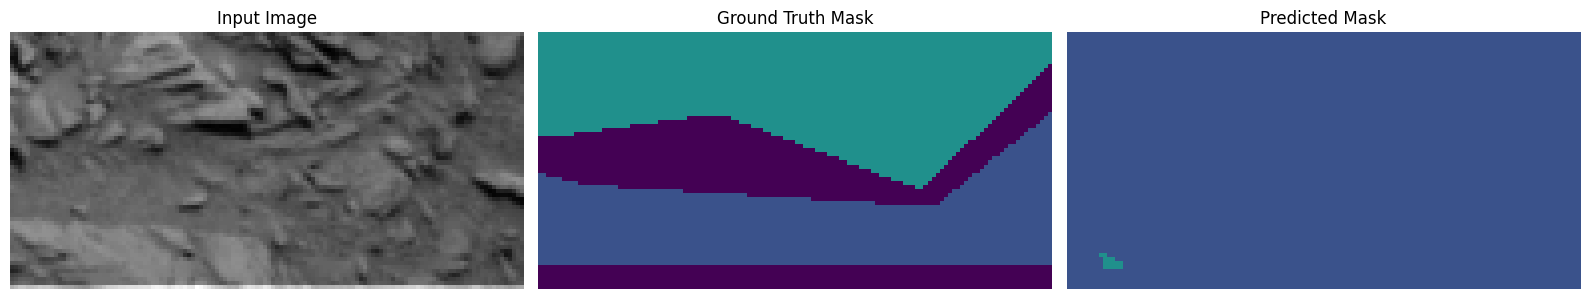

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5440 - loss: 0.5189 - mean_iou: 0.5722 - val_accuracy: 0.6359 - val_loss: 0.5476 - val_mean_iou: 0.5433 - learning_rate: 0.0010
Epoch 37/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.5470 - loss: 0.5135 - mean_iou: 0.5780 - val_accuracy: 0.6292 - val_loss: 0.5406 - val_mean_iou: 0.5704 - learning_rate: 0.0010
Epoch 38/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.5400 - loss: 0.5245 - mean_iou: 0.5617 - val_accuracy: 0.6524 - val_loss: 0.5427 - val_mean_iou: 0.5803 - learning_rate: 0.0010
Epoch 39/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.5513 - loss: 0.5080 - mean_iou: 0.5900 - val_accuracy: 0.6422 - val_loss: 0.5345 - val_mean_iou: 0.5819 - learning_rate: 0.0010
Epoch 40/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.5527 - loss: 0.5063 - mean_iou: 0.5931 - val_accuracy: 0.6426 - val_loss: 0.5238 - val_mean_iou: 0.5993 - learning_rate: 0.0010
Epoch 41/200
251/2

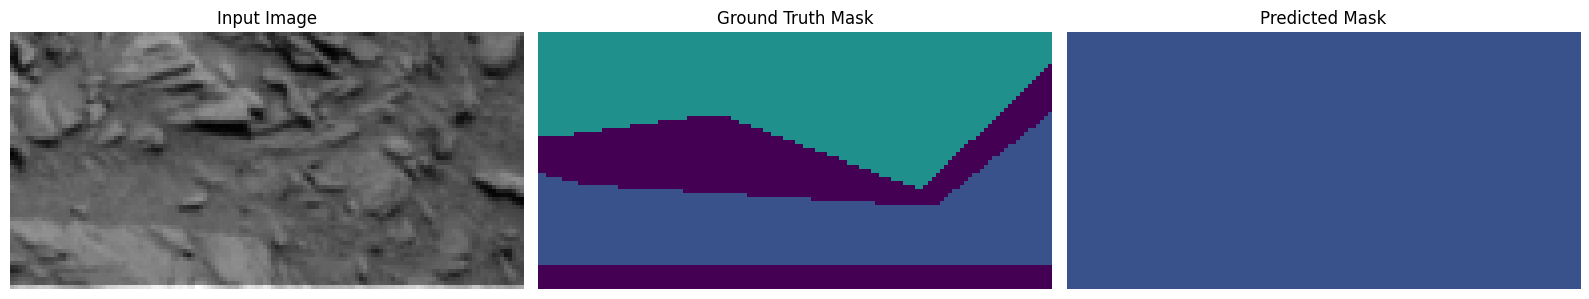

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5433 - loss: 0.5097 - mean_iou: 0.5819 - val_accuracy: 0.6503 - val_loss: 0.5284 - val_mean_iou: 0.6082 - learning_rate: 0.0010
Epoch 42/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.5423 - loss: 0.5141 - mean_iou: 0.5716 - val_accuracy: 0.6604 - val_loss: 0.5318 - val_mean_iou: 0.5989 - learning_rate: 0.0010
Epoch 43/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5553 - loss: 0.5047 - mean_iou: 0.5990 - val_accuracy: 0.6528 - val_loss: 0.5252 - val_mean_iou: 0.6143 - learning_rate: 0.0010
Epoch 44/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5544 - loss: 0.5006 - mean_iou: 0.6026 - val_accuracy: 0.6522 - val_loss: 0.5205 - val_mean_iou: 0.6054 - learning_rate: 0.0010
Epoch 45/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5550 - loss: 0.4961 - mean_iou: 0.6052 - val_accuracy: 0.5477 - val_loss: 0.6826 - val_mean_iou: 0.4702 - learning_rate: 0.0010
Epoch 46/200
251/2

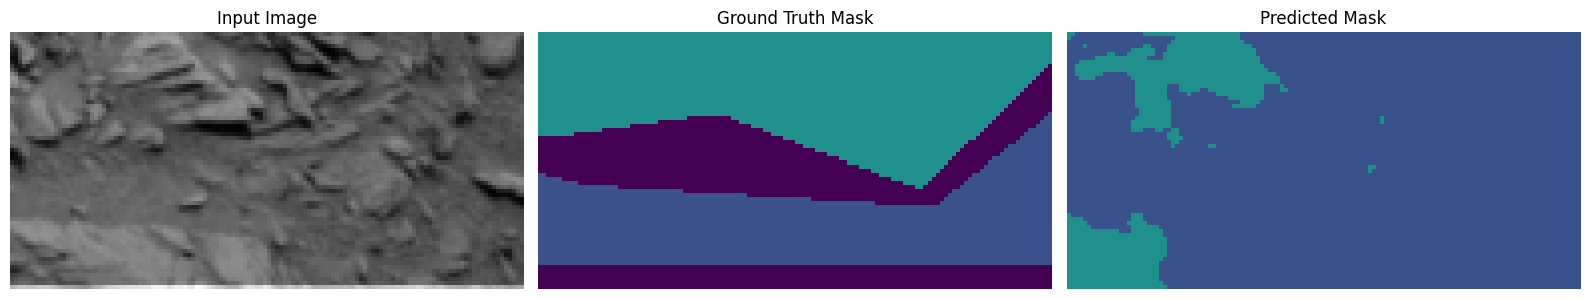

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5450 - loss: 0.5103 - mean_iou: 0.5821 - val_accuracy: 0.6739 - val_loss: 0.5170 - val_mean_iou: 0.6353 - learning_rate: 0.0010
Epoch 47/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5532 - loss: 0.4952 - mean_iou: 0.6065 - val_accuracy: 0.6648 - val_loss: 0.5025 - val_mean_iou: 0.6471 - learning_rate: 0.0010
Epoch 48/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.5479 - loss: 0.4948 - mean_iou: 0.5939 - val_accuracy: 0.6496 - val_loss: 0.5434 - val_mean_iou: 0.5830 - learning_rate: 0.0010
Epoch 49/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.5506 - loss: 0.5006 - mean_iou: 0.5970 - val_accuracy: 0.6387 - val_loss: 0.5439 - val_mean_iou: 0.5726 - learning_rate: 0.0010
Epoch 50/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.5439 - loss: 0.5026 - mean_iou: 0.5882 - val_accuracy: 0.6652 - val_loss: 0.5187 - val_mean_iou: 0.6296 - learning_rate: 0.0010
Epoch 51/200
251/2

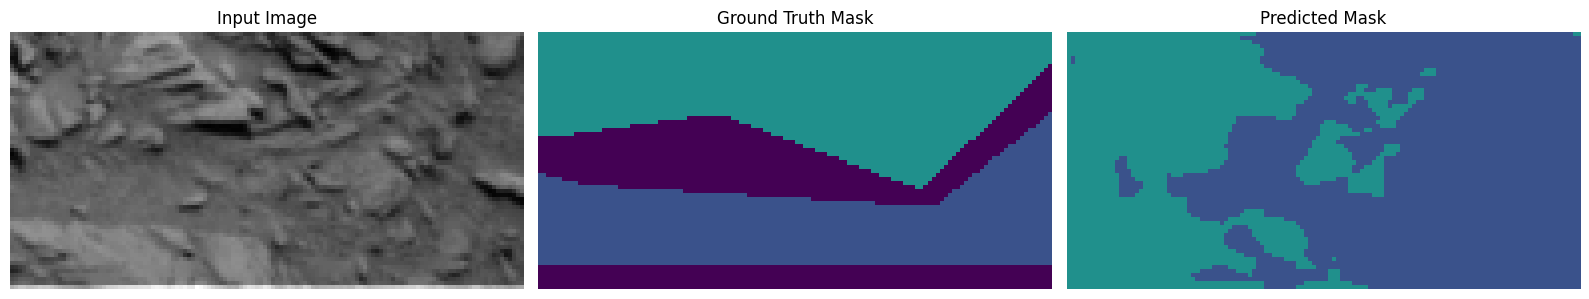

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.5508 - loss: 0.4985 - mean_iou: 0.5941 - val_accuracy: 0.6596 - val_loss: 0.5263 - val_mean_iou: 0.6239 - learning_rate: 0.0010
Epoch 52/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5531 - loss: 0.4953 - mean_iou: 0.5994 - val_accuracy: 0.6619 - val_loss: 0.5183 - val_mean_iou: 0.6505 - learning_rate: 0.0010
Epoch 53/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5593 - loss: 0.4839 - mean_iou: 0.6263 - val_accuracy: 0.6529 - val_loss: 0.5211 - val_mean_iou: 0.6230 - learning_rate: 0.0010
Epoch 54/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5600 - loss: 0.4852 - mean_iou: 0.6209 - val_accuracy: 0.6723 - val_loss: 0.5128 - val_mean_iou: 0.6554 - learning_rate: 0.0010
Epoch 55/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5650 - loss: 0.4741 - mean_iou: 0.6386 - val_accuracy: 0.6058 - val_loss: 0.5523 - val_mean_iou: 0.5217 - learning_rate: 0.0010
Epoch 56/200
251/2

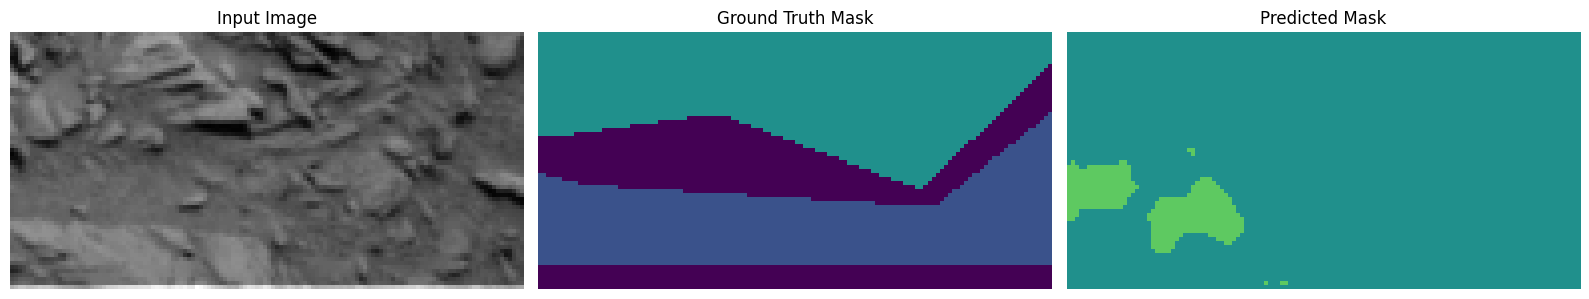

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.5527 - loss: 0.4883 - mean_iou: 0.6137 - val_accuracy: 0.6393 - val_loss: 0.5236 - val_mean_iou: 0.5994 - learning_rate: 0.0010
Epoch 57/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5577 - loss: 0.4898 - mean_iou: 0.6075 - val_accuracy: 0.6553 - val_loss: 0.5314 - val_mean_iou: 0.6191 - learning_rate: 0.0010
Epoch 58/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5557 - loss: 0.4919 - mean_iou: 0.6042 - val_accuracy: 0.6644 - val_loss: 0.5371 - val_mean_iou: 0.5904 - learning_rate: 0.0010
Epoch 59/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5576 - loss: 0.4816 - mean_iou: 0.6198 - val_accuracy: 0.6486 - val_loss: 0.5429 - val_mean_iou: 0.5808 - learning_rate: 0.0010
Epoch 60/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5497 - loss: 0.4911 - mean_iou: 0.5902 - val_accuracy: 0.6707 - val_loss: 0.5314 - val_mean_iou: 0.5991 - learning_rate: 0.0010
Epoch 61/200
251/2

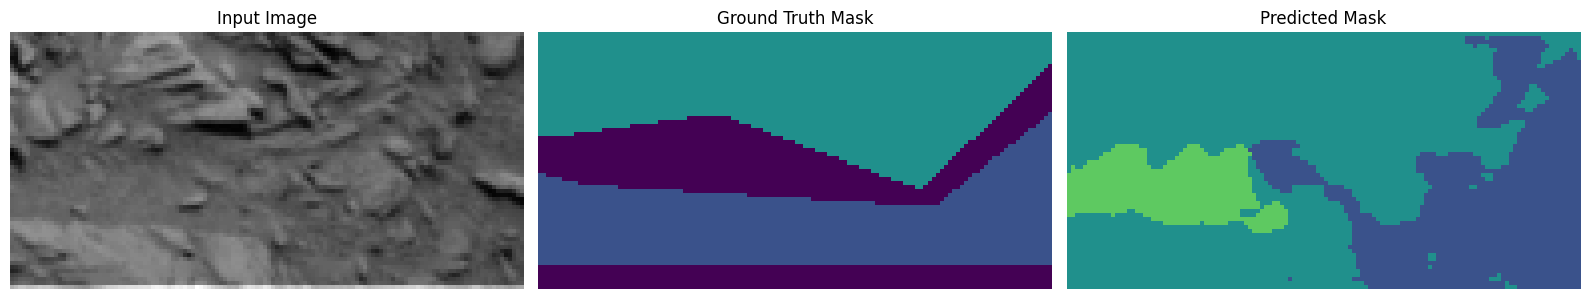

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.5606 - loss: 0.4687 - mean_iou: 0.6366 - val_accuracy: 0.6665 - val_loss: 0.5379 - val_mean_iou: 0.5888 - learning_rate: 0.0010
Epoch 62/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5633 - loss: 0.4670 - mean_iou: 0.6381 - val_accuracy: 0.6697 - val_loss: 0.5383 - val_mean_iou: 0.5952 - learning_rate: 0.0010
Epoch 63/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5668 - loss: 0.4636 - mean_iou: 0.6493 - val_accuracy: 0.6395 - val_loss: 0.5361 - val_mean_iou: 0.5803 - learning_rate: 0.0010
Epoch 64/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5635 - loss: 0.4628 - mean_iou: 0.6448 - val_accuracy: 0.5617 - val_loss: 0.5481 - val_mean_iou: 0.5195 - learning_rate: 0.0010
Epoch 65/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5567 - loss: 0.4737 - mean_iou: 0.6228 - val_accuracy: 0.6726 - val_loss: 0.5202 - val_mean_iou: 0.6337 - learning_rate: 0.0010
Epoch 66/200
251/2

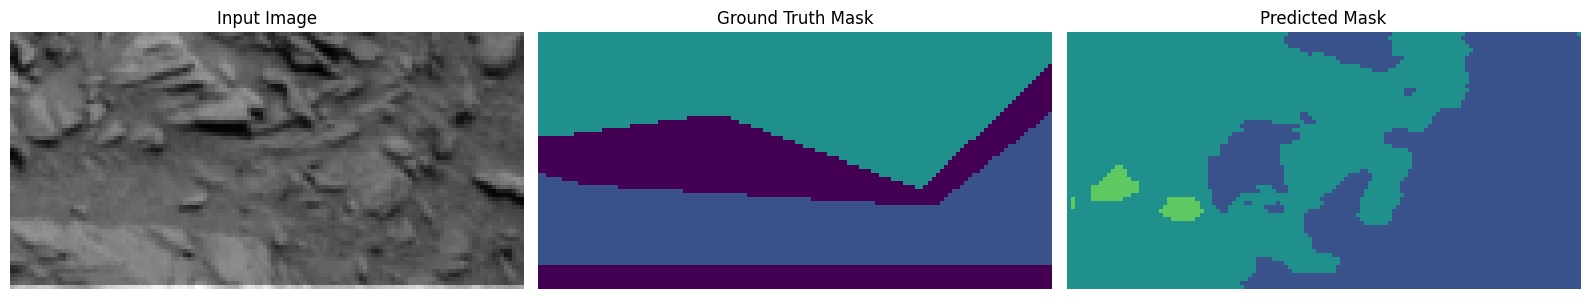

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5609 - loss: 0.4726 - mean_iou: 0.6342 - val_accuracy: 0.6505 - val_loss: 0.5268 - val_mean_iou: 0.6094 - learning_rate: 0.0010
Epoch 67/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5628 - loss: 0.4619 - mean_iou: 0.6474 - val_accuracy: 0.6558 - val_loss: 0.5213 - val_mean_iou: 0.6377 - learning_rate: 0.0010
Epoch 68/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5645 - loss: 0.4556 - mean_iou: 0.6490 - val_accuracy: 0.6573 - val_loss: 0.5245 - val_mean_iou: 0.6208 - learning_rate: 0.0010
Epoch 69/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5614 - loss: 0.4596 - mean_iou: 0.6438 - val_accuracy: 0.6712 - val_loss: 0.5259 - val_mean_iou: 0.6168 - learning_rate: 0.0010
Epoch 70/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5622 - loss: 0.4551 - mean_iou: 0.6485 - val_accuracy: 0.6614 - val_loss: 0.5286 - val_mean_iou: 0.6053 - learning_rate: 0.0010
Epoch 71/200
251/2

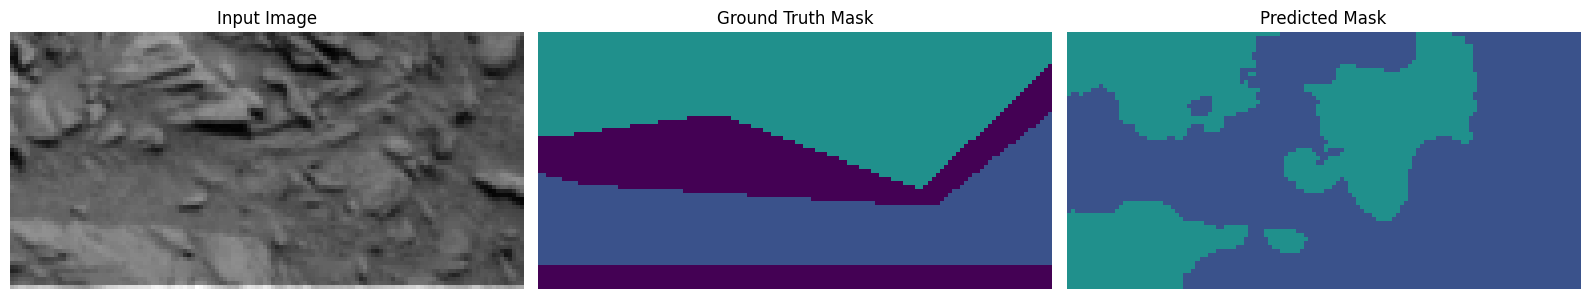

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5697 - loss: 0.4481 - mean_iou: 0.6619 - val_accuracy: 0.6765 - val_loss: 0.5163 - val_mean_iou: 0.6509 - learning_rate: 0.0010
Epoch 72/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5676 - loss: 0.4480 - mean_iou: 0.6597 - val_accuracy: 0.6720 - val_loss: 0.5302 - val_mean_iou: 0.6107 - learning_rate: 0.0010
Epoch 73/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5705 - loss: 0.4433 - mean_iou: 0.6691 - val_accuracy: 0.6694 - val_loss: 0.5371 - val_mean_iou: 0.6000 - learning_rate: 0.0010
Epoch 74/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5689 - loss: 0.4419 - mean_iou: 0.6663 - val_accuracy: 0.6774 - val_loss: 0.5288 - val_mean_iou: 0.6117 - learning_rate: 0.0010
Epoch 75/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5625 - loss: 0.4577 - mean_iou: 0.6433 - val_accuracy: 0.6636 - val_loss: 0.5168 - val_mean_iou: 0.6448 - learning_rate: 0.0010
Epoch 76/200
251/2

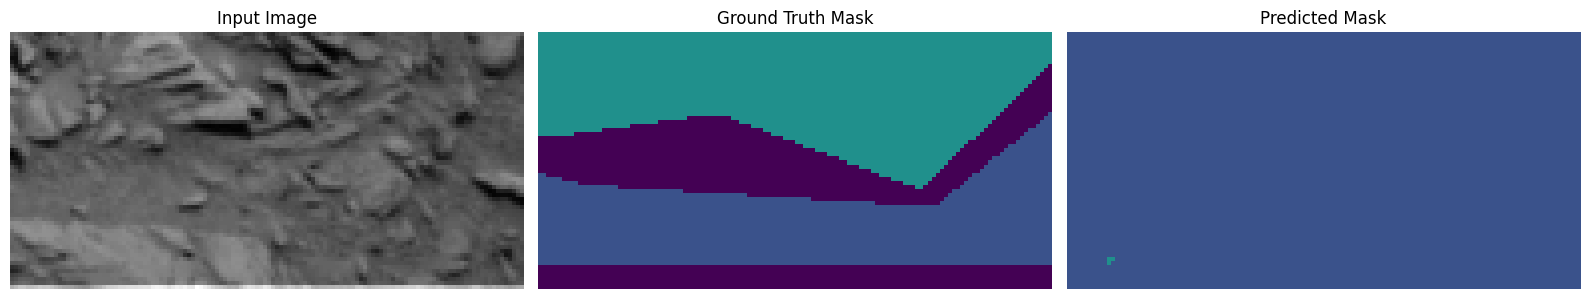

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5675 - loss: 0.4476 - mean_iou: 0.6644 - val_accuracy: 0.6555 - val_loss: 0.5388 - val_mean_iou: 0.5847 - learning_rate: 0.0010
Epoch 77/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.5665 - loss: 0.4412 - mean_iou: 0.6567 - val_accuracy: 0.6743 - val_loss: 0.5025 - val_mean_iou: 0.6669 - learning_rate: 0.0010
Epoch 78/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5743 - loss: 0.4352 - mean_iou: 0.6841 - val_accuracy: 0.6851 - val_loss: 0.5028 - val_mean_iou: 0.6780 - learning_rate: 1.0000e-04
Epoch 79/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5791 - loss: 0.4243 - mean_iou: 0.6996 - val_accuracy: 0.6855 - val_loss: 0.5085 - val_mean_iou: 0.6635 - learning_rate: 1.0000e-04
Epoch 80/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5803 - loss: 0.4213 - mean_iou: 0.7042 - val_accuracy: 0.6845 - val_loss: 0.5113 - val_mean_iou: 0.6564 - learning_rate: 1.0000e-04
Epoch 

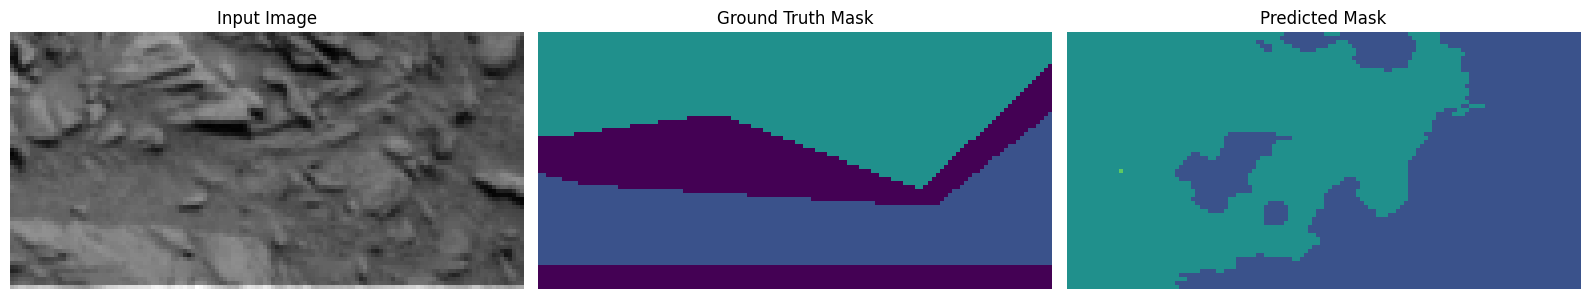

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5811 - loss: 0.4187 - mean_iou: 0.7080 - val_accuracy: 0.6845 - val_loss: 0.5142 - val_mean_iou: 0.6503 - learning_rate: 1.0000e-04
Epoch 82/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5819 - loss: 0.4168 - mean_iou: 0.7103 - val_accuracy: 0.6845 - val_loss: 0.5132 - val_mean_iou: 0.6527 - learning_rate: 1.0000e-04
Epoch 83/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5824 - loss: 0.4151 - mean_iou: 0.7122 - val_accuracy: 0.6837 - val_loss: 0.5181 - val_mean_iou: 0.6422 - learning_rate: 1.0000e-04
Epoch 84/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5819 - loss: 0.4154 - mean_iou: 0.7106 - val_accuracy: 0.6828 - val_loss: 0.5192 - val_mean_iou: 0.6383 - learning_rate: 1.0000e-04
Epoch 85/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5820 - loss: 0.4137 - mean_iou: 0.7104 - val_accuracy: 0.6839 - val_loss: 0.5181 - val_mean_iou: 0.6429 - learning_rate: 1.0000e-0

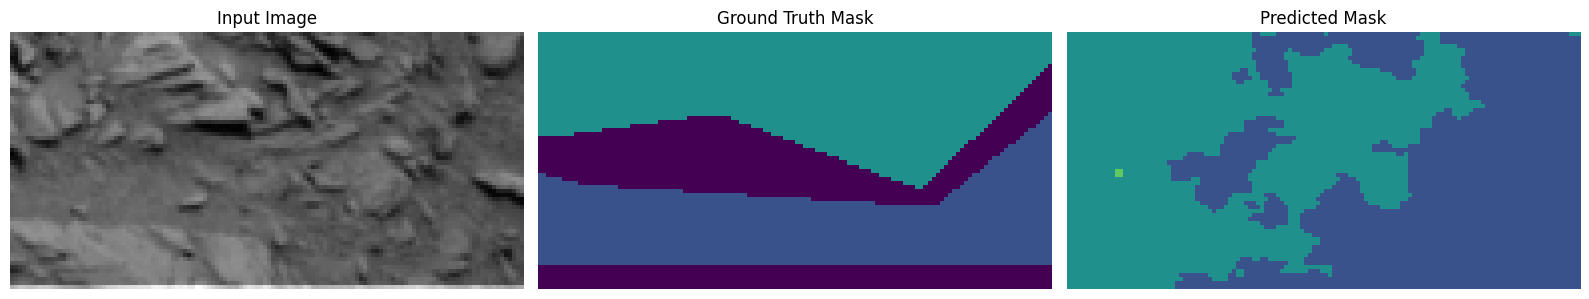

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5827 - loss: 0.4120 - mean_iou: 0.7142 - val_accuracy: 0.6843 - val_loss: 0.5188 - val_mean_iou: 0.6421 - learning_rate: 1.0000e-04
Epoch 87/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5832 - loss: 0.4109 - mean_iou: 0.7161 - val_accuracy: 0.6838 - val_loss: 0.5177 - val_mean_iou: 0.6425 - learning_rate: 1.0000e-04
Epoch 88/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5832 - loss: 0.4096 - mean_iou: 0.7160 - val_accuracy: 0.6842 - val_loss: 0.5183 - val_mean_iou: 0.6424 - learning_rate: 1.0000e-04
Epoch 89/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5838 - loss: 0.4084 - mean_iou: 0.7191 - val_accuracy: 0.6842 - val_loss: 0.5182 - val_mean_iou: 0.6422 - learning_rate: 1.0000e-04
Epoch 90/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5841 - loss: 0.4068 - mean_iou: 0.7192 - val_accuracy: 0.6840 - val_loss: 0.5190 - val_mean_iou: 0.6415 - learning_rate: 1.0000e-0

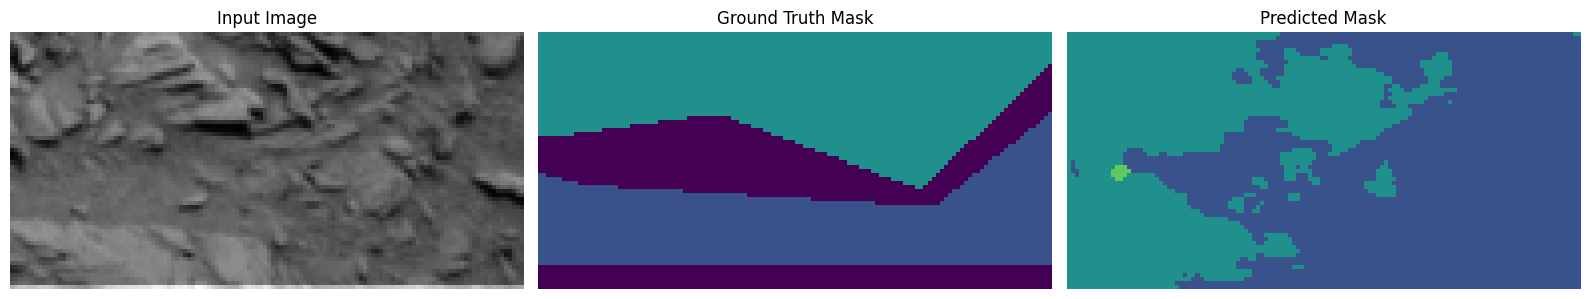

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.5842 - loss: 0.4074 - mean_iou: 0.7193 - val_accuracy: 0.6839 - val_loss: 0.5187 - val_mean_iou: 0.6416 - learning_rate: 1.0000e-04
Epoch 92/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5846 - loss: 0.4064 - mean_iou: 0.7219 - val_accuracy: 0.6836 - val_loss: 0.5197 - val_mean_iou: 0.6382 - learning_rate: 1.0000e-04
Epoch 93/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5849 - loss: 0.4045 - mean_iou: 0.7230 - val_accuracy: 0.6839 - val_loss: 0.5184 - val_mean_iou: 0.6412 - learning_rate: 1.0000e-04
Epoch 94/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5850 - loss: 0.4035 - mean_iou: 0.7238 - val_accuracy: 0.6835 - val_loss: 0.5195 - val_mean_iou: 0.6392 - learning_rate: 1.0000e-04
Epoch 95/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5847 - loss: 0.4039 - mean_iou: 0.7240 - val_accuracy: 0.6787 - val_loss: 0.5237 - val_mean_iou: 0.6273 - learning_rate: 1.0000e-0

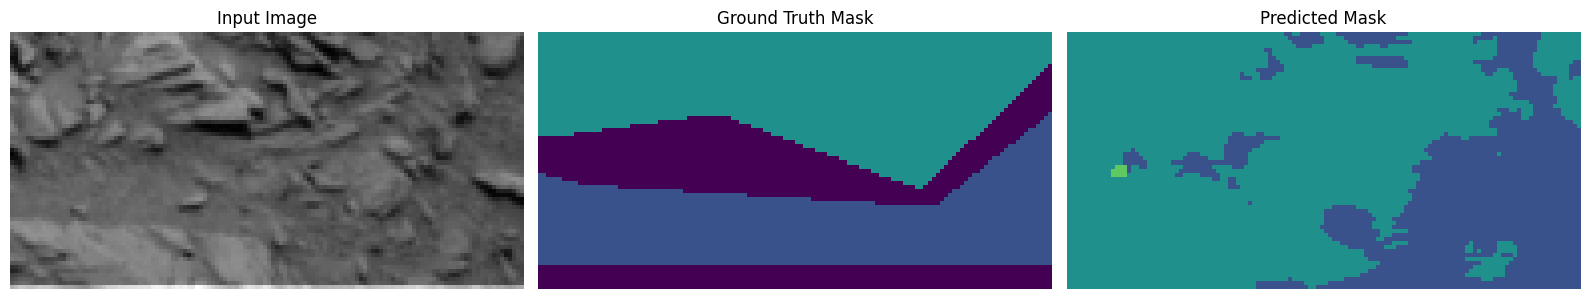

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5848 - loss: 0.4025 - mean_iou: 0.7212 - val_accuracy: 0.6837 - val_loss: 0.5202 - val_mean_iou: 0.6414 - learning_rate: 1.0000e-04
Epoch 97/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5852 - loss: 0.3999 - mean_iou: 0.7267 - val_accuracy: 0.6841 - val_loss: 0.5220 - val_mean_iou: 0.6368 - learning_rate: 1.0000e-04
Epoch 98/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5856 - loss: 0.4000 - mean_iou: 0.7273 - val_accuracy: 0.6836 - val_loss: 0.5219 - val_mean_iou: 0.6364 - learning_rate: 1.0000e-04
Epoch 99/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.5862 - loss: 0.3996 - mean_iou: 0.7285 - val_accuracy: 0.6839 - val_loss: 0.5199 - val_mean_iou: 0.6391 - learning_rate: 1.0000e-04
Epoch 100/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5865 - loss: 0.3979 - mean_iou: 0.7298 - val_accuracy: 0.6837 - val_loss: 0.5214 - val_mean_iou: 0.6360 - learning_rate: 1.0000e-

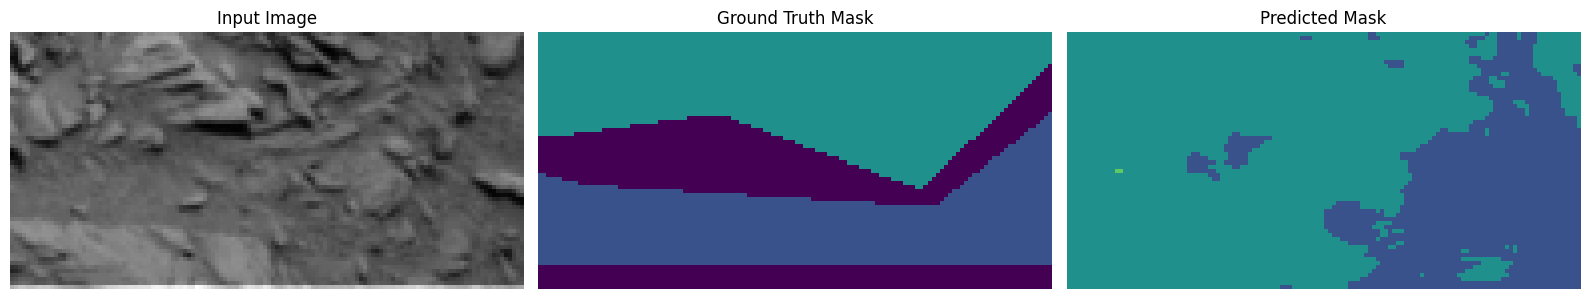

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5870 - loss: 0.3971 - mean_iou: 0.7305 - val_accuracy: 0.6850 - val_loss: 0.5206 - val_mean_iou: 0.6402 - learning_rate: 1.0000e-04
Epoch 102/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5868 - loss: 0.3968 - mean_iou: 0.7315 - val_accuracy: 0.6833 - val_loss: 0.5239 - val_mean_iou: 0.6307 - learning_rate: 1.0000e-04
Epoch 103/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5869 - loss: 0.3969 - mean_iou: 0.7300 - val_accuracy: 0.6843 - val_loss: 0.5210 - val_mean_iou: 0.6399 - learning_rate: 1.0000e-04
Epoch 104/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5873 - loss: 0.3955 - mean_iou: 0.7335 - val_accuracy: 0.6839 - val_loss: 0.5216 - val_mean_iou: 0.6368 - learning_rate: 1.0000e-04
Epoch 105/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5877 - loss: 0.3953 - mean_iou: 0.7341 - val_accuracy: 0.6832 - val_loss: 0.5234 - val_mean_iou: 0.6328 - learning_rate: 1.000

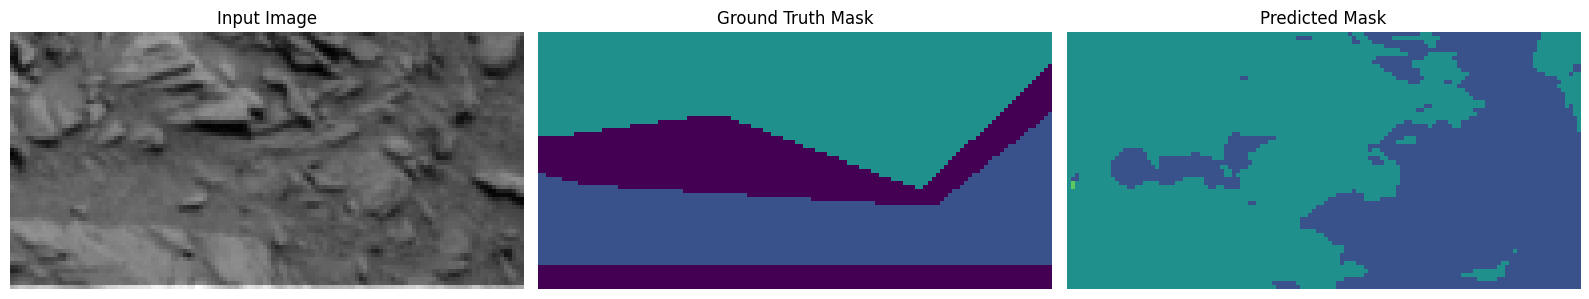

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.5876 - loss: 0.3949 - mean_iou: 0.7330 - val_accuracy: 0.6846 - val_loss: 0.5226 - val_mean_iou: 0.6361 - learning_rate: 1.0000e-04
Epoch 107/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5879 - loss: 0.3949 - mean_iou: 0.7347 - val_accuracy: 0.6833 - val_loss: 0.5217 - val_mean_iou: 0.6346 - learning_rate: 1.0000e-04
Epoch 108/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5885 - loss: 0.3934 - mean_iou: 0.7372 - val_accuracy: 0.6844 - val_loss: 0.5223 - val_mean_iou: 0.6359 - learning_rate: 1.0000e-05
Epoch 109/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5890 - loss: 0.3926 - mean_iou: 0.7391 - val_accuracy: 0.6844 - val_loss: 0.5225 - val_mean_iou: 0.6354 - learning_rate: 1.0000e-05
Epoch 110/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5890 - loss: 0.3923 - mean_iou: 0.7387 - val_accuracy: 0.6845 - val_loss: 0.5227 - val_mean_iou: 0.6350 - learning_rate: 1.000

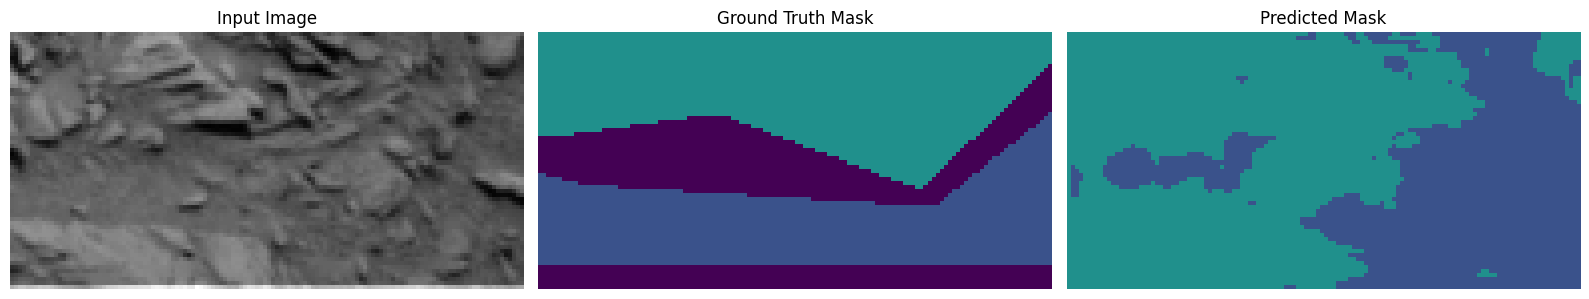

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5890 - loss: 0.3919 - mean_iou: 0.7389 - val_accuracy: 0.6847 - val_loss: 0.5226 - val_mean_iou: 0.6353 - learning_rate: 1.0000e-05
Epoch 112/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5890 - loss: 0.3914 - mean_iou: 0.7390 - val_accuracy: 0.6847 - val_loss: 0.5224 - val_mean_iou: 0.6357 - learning_rate: 1.0000e-05
Epoch 113/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5889 - loss: 0.3913 - mean_iou: 0.7392 - val_accuracy: 0.6847 - val_loss: 0.5225 - val_mean_iou: 0.6355 - learning_rate: 1.0000e-05
Epoch 114/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5889 - loss: 0.3910 - mean_iou: 0.7395 - val_accuracy: 0.6848 - val_loss: 0.5225 - val_mean_iou: 0.6358 - learning_rate: 1.0000e-05
Epoch 115/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.5891 - loss: 0.3906 - mean_iou: 0.7404 - val_accuracy: 0.6847 - val_loss: 0.5222 - val_mean_iou: 0.6361 - learning_rate: 1.000

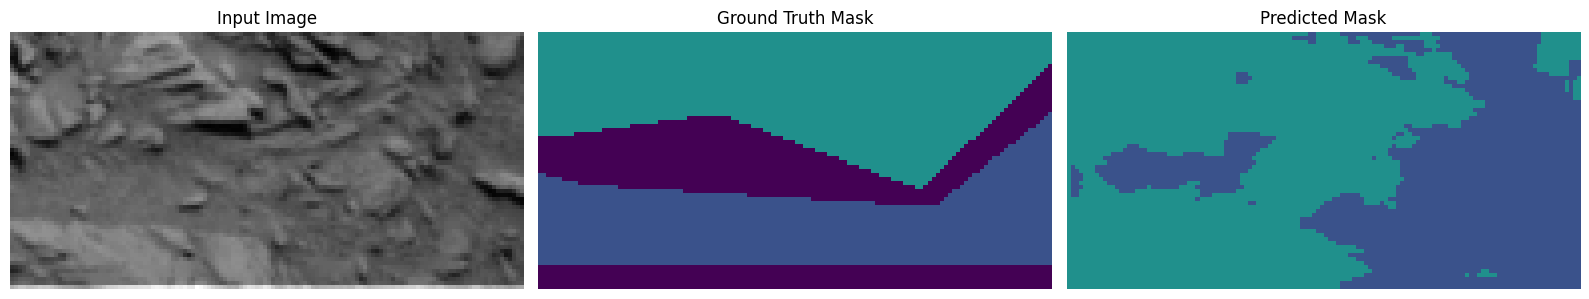

251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.5889 - loss: 0.3905 - mean_iou: 0.7401 - val_accuracy: 0.6847 - val_loss: 0.5223 - val_mean_iou: 0.6359 - learning_rate: 1.0000e-05
Epoch 117/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.5891 - loss: 0.3903 - mean_iou: 0.7405 - val_accuracy: 0.6850 - val_loss: 0.5222 - val_mean_iou: 0.6362 - learning_rate: 1.0000e-05
Epoch 118/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.5891 - loss: 0.3901 - mean_iou: 0.7405 - val_accuracy: 0.6850 - val_loss: 0.5225 - val_mean_iou: 0.6359 - learning_rate: 1.0000e-05
Final validation Mean Intersection Over Union: 67.8%


In [29]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

In [30]:
history.keys()

dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou', 'learning_rate'])

In [31]:
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Final validation Mean Intersection Over Union: 67.8%


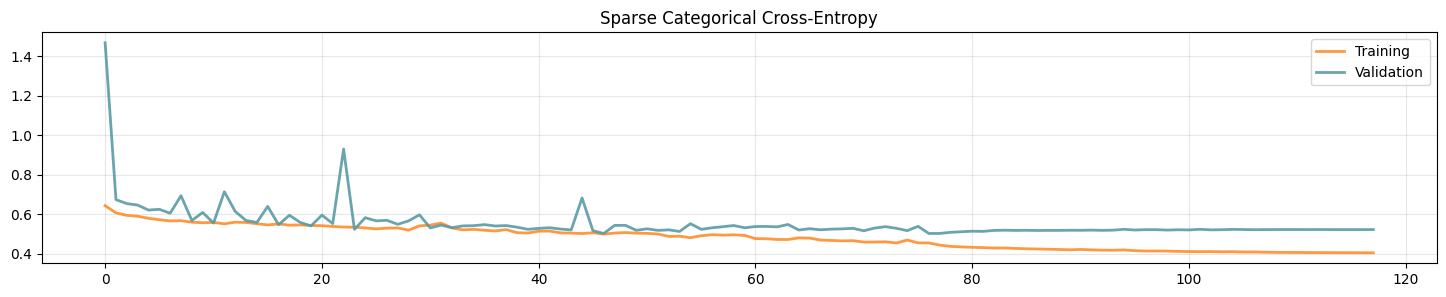

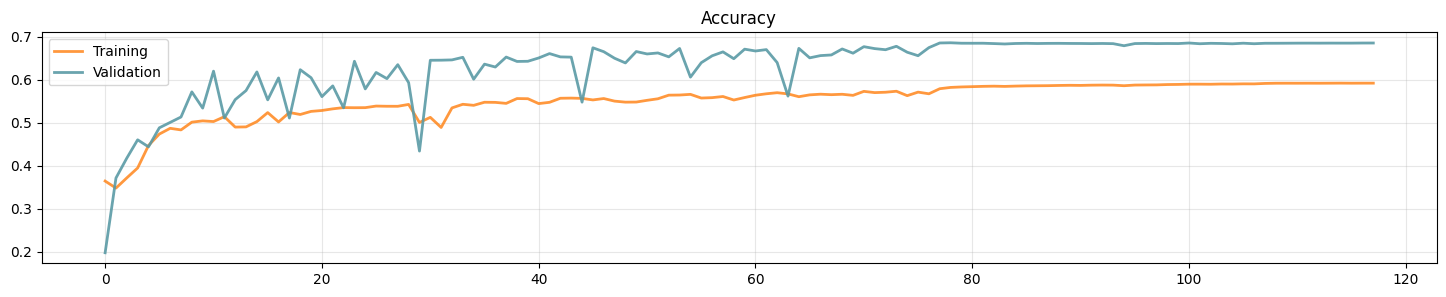

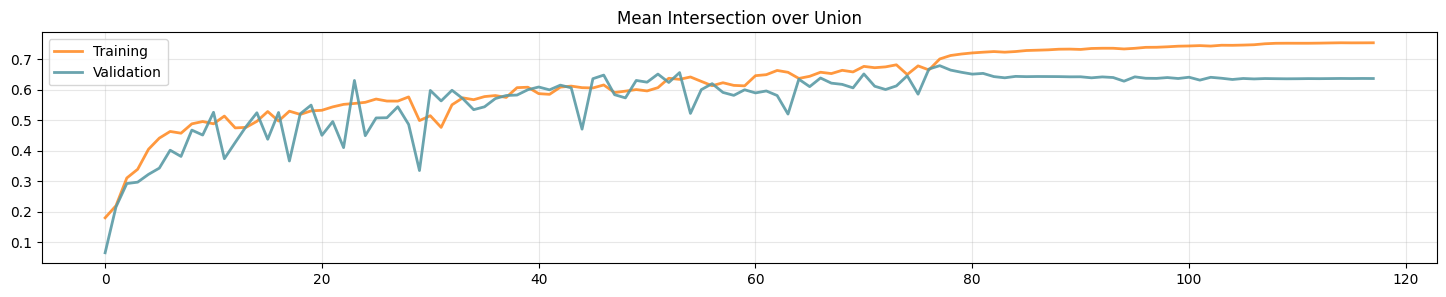

In [32]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Sparse Categorical Cross-Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [33]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241204_004622.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.

In [34]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [35]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241204_004622.keras


In [36]:
# Custom compiling due to custom metric MeanIOU defined
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

In [37]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step
Predictions shape: (10022, 64, 128)


In [38]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [39]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

print("CSV created in the output folder: ", submission_filename)

CSV created in the output folder:  submission_241204_004622.csv
